# 1. Idea general del modelo

modelo simple de **Stechmann & Neelin (2014)** para la humedad de columna $q(t)$:

Hay dos estados:



## **Estado seco** (no llueve, $s = 0$):

$\frac{dq}{dt} = E^{*} + D_{0}\,\xi(t)$



## **Estado lluvioso** (llueve, $s = 1$):

$\frac{dq}{dt} = -P^{*} + D_{1}\,\xi(t)$



### Donde:

- $E^{*}$ es una tendencia constante que aumenta $q$ cuando está seco (evaporación).  
- $P^{*}$ es una tendencia constante que disminuye $q$ cuando llueve (precipitación).  
- $D_{0}$ y $D_{1}$ son amplitudes del ruido (en mm / $\sqrt{\text{hora}}$).  
- $\xi(t)$ es ruido blanco gaussiano.



### Además, hay umbrales:

- Si está seco y $q$ sube hasta $q_c$, pasa a estado lluvioso.  
- Si está lluvioso y $q$ baja hasta $q_{np}$, vuelve a seco.


In [1]:
!pip install numpy matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True


- **T_hours = 2000.0**: duración total de la simulación = 2000 horas.

- **dt_minutes = 1.0**: paso de tiempo = 1 minuto.

- **E_star = 0.4 mm/h**: tendencia en estado seco (evaporación).

- **P_star = 3.0 mm/h**: tendencia en estado húmedo (precipitación).

- **D0_var = 8.0 mm²/h**: esta es $(D_0)^2$, la varianza del ruido en estado seco.  
  En la práctica usamos $D_0 = 8$.

- **D1_var = 64.0 mm²/h**: esta es $(D_1)^2$, la varianza del ruido en estado lluvioso.  
  Usamos $D_1 = 64 = 8$.

- **qc = 65.0 mm**: umbral superior; cuando $q$ llega aquí desde un estado seco, empieza a llover.

- **qnp = 62.0 mm**: umbral inferior; cuando $q$ baja de esto en estado húmedo, deja de llover.

- **q0 = 63.0 mm**: condición inicial de $q$.

- **s0 = 0**: estado inicial, partimos seco.

- **seed**: semilla del generador aleatorio (para poder reproducir los resultados).


In [3]:
def enforce_q_nonnegative(q_next, q_prev, mode="reflect"):
    """
    Salvaguardas para asegurar q >= 0.

    mode:
      - "clip"    : q = max(q, 0)        (pared absorbente; lo que tenía)
      - "reflect" : q = abs(q)           (pared reflectante)
      - "stay"    : si q<0, q = q_prev   (no permite el salto negativo)
      - "resample": si q<0, re-muestrea el ruido hasta que q>=0 (más caro)
    """
    if q_next >= 0:
        return q_next

    if mode == "clip":
        return 0.0

    if mode == "reflect":
        return abs(q_next)

    if mode == "stay":
        return q_prev

    if mode == "resample":
        # Ojo: este modo requiere que el llamador lo implemente dentro del loop,
        # porque necesita re-samplear dW. Aquí no se puede sin saber drift, D, dt.
        raise ValueError("mode='resample' debe implementarse dentro del loop con dW.")

    raise ValueError(f"Modo desconocido: {mode}")


Usamos una salvaguarda reflectante, o sea que cuando en un paso aparece $q_{n+1} < 0$, en vez de recordarlo a cero (pared absorbente), lo reflejo y tomo

$q_{n+1} \leftarrow |q_{n+1}|$

Probé varias (clip/reflect/stay) y para los resultados que estoy mostrando fijé q_floor_mode="reflect"

Si clipeo, entonces genero una pared absorbente, tiende a acumular probabilidad cerca de 0 cuando el ruido es grande. 

Con Reflexión, la serie no se queda atrapada en 0 y la estadistica de spells cambia menos.

In [4]:
# ===========================================
# Celda 2: Modelo simple de Stechmann & Neelin (2014)
# ===========================================

def simulate_SN14(
    T_hours=876000.0,
    dt_minutes=1.0,
    E_star=0.4,      # mm/h (evaporación)
    P_star=3.0,      # mm/h (precipitación cuando llueve)
    D0_var=8.0,      # D0^2 en mm^2/h (varianza del ruido en estado seco)
    D1_var=64.0,     # D1^2 en mm^2/h (varianza del ruido en estado húmedo)
    qc=65.0,         # umbral alto (mm)
    qnp=62.0,        # umbral bajo (mm)
    q0=63.0,         # condición inicial de q
    s0=0,            # 0: seco, 1: lluvioso
    seed=None,
    q_floor_mode="stay"
):
    """
    Simula el modelo de Stechmann & Neelin (2014) de dos estados.

    Devuelve:
      t       : tiempo (horas)
      q       : serie de CWV (mm)
      s       : estado (0 seco, 1 lluvioso)
      precip  : tasa de precipitación (mm/h)
    """
    if seed is not None:
        np.random.seed(seed)

    dt = dt_minutes / 60.0      # paso temporal en horas
    nsteps = int(T_hours / dt)

    # Amplitud del ruido (D0 y D1)
    D0 = np.sqrt(D0_var)
    D1 = np.sqrt(D1_var)

    t = np.linspace(0, T_hours, nsteps+1)
    q = np.zeros(nsteps+1)
    s = np.zeros(nsteps+1, dtype=int)
    precip = np.zeros(nsteps+1)

    q[0] = q0
    s[0] = s0
    precip[0] = P_star if s0 == 1 else 0.0

    for n in range(nsteps):
        if s[n] == 0:
            # estado seco
            drift = E_star
            D = D0
        else:
            # estado húmedo (precipitando)
            drift = -P_star
            D = D1

        # incremento de Wiener ~ N(0, dt)
        dW = np.sqrt(dt) * np.random.randn()

        # integración de Euler–Maruyama
        q[n+1] = q[n] + drift*dt + D * dW
        q[n+1] = enforce_q_nonnegative(q[n+1], q[n], mode=q_floor_mode)


        # Actualizar estado según umbrales
        if s[n] == 0 and q[n+1] >= qc:
            s[n+1] = 1
        elif s[n] == 1 and q[n+1] <= qnp:
            s[n+1] = 0
        else:
            s[n+1] = s[n]

        precip[n+1] = P_star if s[n+1] == 1 else 0.0

    return t, q, s, precip


def get_spell_durations(state_series, dt_hours, wet=True):
    """
    Calcula duraciones de spells (secos o lluviosos).

    wet=True  -> duraciones de episodios con s==1 (lluvia)
    wet=False -> duraciones de episodios con s==0 (seco)
    """
    target = 1 if wet else 0
    durations = []
    current_len = 0

    for s in state_series:
        if s == target:
            current_len += 1
        else:
            if current_len > 0:
                durations.append(current_len * dt_hours)
                current_len = 0

    # por si la serie termina en medio de un spell
    if current_len > 0:
        durations.append(current_len * dt_hours)

    return np.array(durations)


def tM_from_durations(durations):
    """
    tM = var(duración) / mean(duración)

    Devuelve NaN si hay muy pocas duraciones.
    """
    if len(durations) < 2:
        return np.nan
    return np.var(durations) / np.mean(durations)


Longitud de la serie: 52560001 puntos
q (primeros 10): [63.         63.18804103 63.14422071 63.38738979 63.95018833 63.87135428
 63.79252621 64.37583987 64.66273408 64.49797294]
P (primeros 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


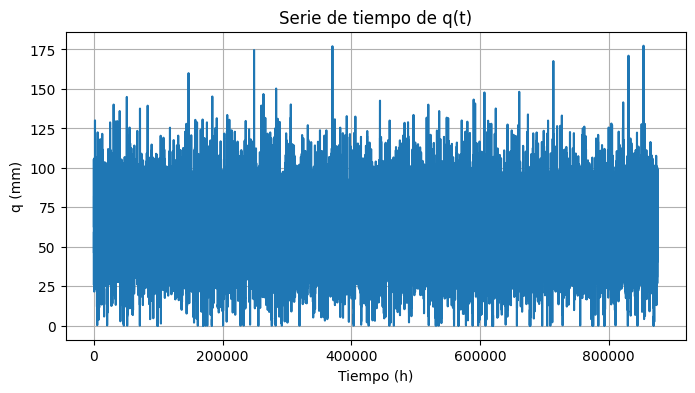

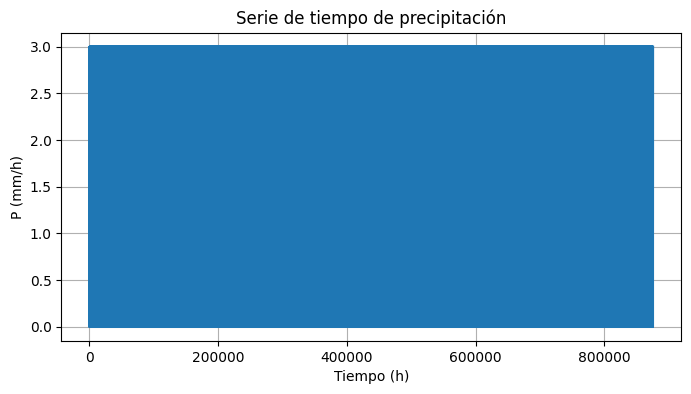

In [5]:
# ==================================================
# Celda 3: Simulación base y series de tiempo
# ==================================================

# Parámetros base (puede ajustarlos)
T_hours = 876000       # duración total de la simulación en horas
dt_minutes = 1.0     # paso de tiempo en minutos

t, q, s, precip = simulate_SN14(
    T_hours=T_hours,
    dt_minutes=dt_minutes,
    D0_var=8.0,
    D1_var=64.0,
    qc=65.0,
    qnp=62.0,
    q0=63.0,
    s0=0,
    seed=42
)

print("Longitud de la serie:", len(t), "puntos")
print("q (primeros 10):", q[:10])
print("P (primeros 10):", precip[:10])

# --- Gráfica de q(t) (puede ampliar/recortar el intervalo para ver mejor) ---
plt.figure()
plt.plot(t, q)
plt.xlabel("Tiempo (h)")
plt.ylabel("q (mm)")
plt.title("Serie de tiempo de q(t)")
plt.show()

# --- Gráfica de precipitación P(t) ---
plt.figure()
plt.plot(t, precip)
plt.xlabel("Tiempo (h)")
plt.ylabel("P (mm/h)")
plt.title("Serie de tiempo de precipitación")
plt.show()


Podemos ver que los primeros valores de P son puros 0, y el modelo SN14 genera precipitación solo cuando q supera q_c


In [6]:
# ===========================================
# Modelo 2: "ramp precipitation"
#  P(q) = lambda_ramp * max(q - qc, 0)
# ===========================================

def simulate_SN14_ramp(
    T_hours=876000.0,
    dt_minutes=1.0,
    E_star=0.4,        # mm/h (fuente seca)
    lambda_ramp=0.2,   # pendiente de la rampa de precipitación
    D0_var=8.0,        # varianza del ruido (mm^2/h)
    D1_var=64.0,       # opcional: ruido mayor cuando llueve
    qc=65.0,           # umbral de inicio de precipitación (mm)
    q0=63.0,           # condición inicial (mm)
    seed=None,
    q_floor_mode="reflect"
):
    """
    Modelo con precipitación tipo "rampa":
      P(q) = lambda_ramp * max(q - qc, 0)

    Devuelve:
      t       : tiempo (horas)
      q       : CWV (mm)
      s       : 0 seco, 1 con precipitación (diagnóstico)
      precip  : tasa de precipitación (mm/h)
    """
    if seed is not None:
        np.random.seed(seed)

    dt = dt_minutes / 60.0
    nsteps = int(T_hours / dt)

    D0 = np.sqrt(D0_var)
    D1 = np.sqrt(D1_var)

    t = np.linspace(0, T_hours, nsteps+1)
    q = np.zeros(nsteps+1)
    s = np.zeros(nsteps+1, dtype=int)
    precip = np.zeros(nsteps+1)

    q[0] = q0
    precip[0] = lambda_ramp * max(q[0] - qc, 0.0)
    s[0] = 1 if precip[0] > 0 else 0

    for n in range(nsteps):

        # precipitación tipo rampa en el tiempo n
        precip[n] = lambda_ramp * max(q[n] - qc, 0.0)

        # etiqueta diagnóstica de estado
        s[n] = 1 if precip[n] > 0 else 0

        # drift: fuente seca - precipitación
        drift = E_star - precip[n]

        # ruido: más fuerte cuando llueve (opcional)
        D = D1 if s[n] == 1 else D0

        dW = np.sqrt(dt) * np.random.randn()
        q[n+1] = q[n] + drift*dt + D * dW
        q[n+1] = enforce_q_nonnegative(q[n+1], q[n], mode=q_floor_mode)


    # definir precipitación y estado en el último punto
    precip[-1] = lambda_ramp * max(q[-1] - qc, 0.0)
    s[-1] = 1 if precip[-1] > 0 else 0

    return t, q, s, precip


Longitud de la serie: 52560001 puntos
q (primeros 10): [63.         63.18804103 63.14422071 63.38738979 63.95018833 63.87135428
 63.79252621 64.37583987 64.66273408 64.49797294]
P (primeros 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


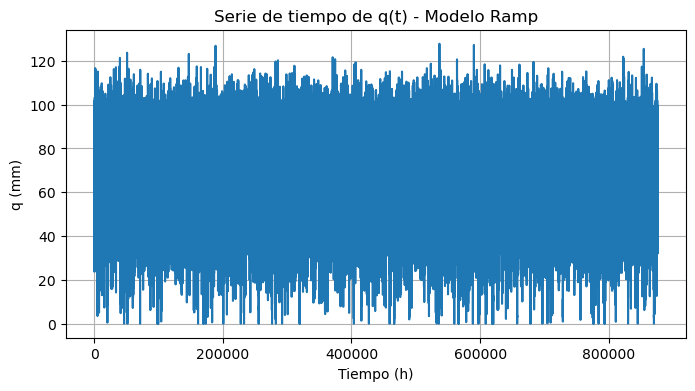

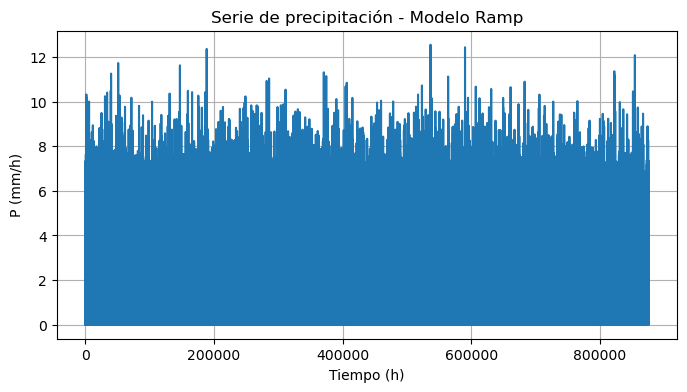

In [6]:
# ==================================================
# Celda 3: Simulación base y series de tiempo (RAMP)
# ==================================================

# Parámetros base (puede ajustarlos)
T_hours = 876000       # duración total de la simulación en horas
dt_minutes = 1.0       # paso de tiempo en minutos

t, q, s, precip = simulate_SN14_ramp(
    T_hours=T_hours,
    dt_minutes=dt_minutes,
    E_star=0.4,
    lambda_ramp=0.2,      # puedes probar 0.1–0.3 para ver diferencias
    D0_var=8.0,
    D1_var=64.0,
    qc=65.0,
    q0=63.0,
    seed=42
)

print("Longitud de la serie:", len(t), "puntos")
print("q (primeros 10):", q[:10])
print("P (primeros 10):", precip[:10])

# --- Gráfica de q(t) ---
plt.figure()
plt.plot(t, q)
plt.xlabel("Tiempo (h)")
plt.ylabel("q (mm)")
plt.title("Serie de tiempo de q(t) - Modelo Ramp")
plt.show()

# --- Gráfica de precipitación ---
plt.figure()
plt.plot(t, precip)
plt.xlabel("Tiempo (h)")
plt.ylabel("P (mm/h)")
plt.title("Serie de precipitación - Modelo Ramp")
plt.show()


**Comparativa**

Switch: 10512001 puntos
Ramp: 10512001 puntos


C:\Users\pgome\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


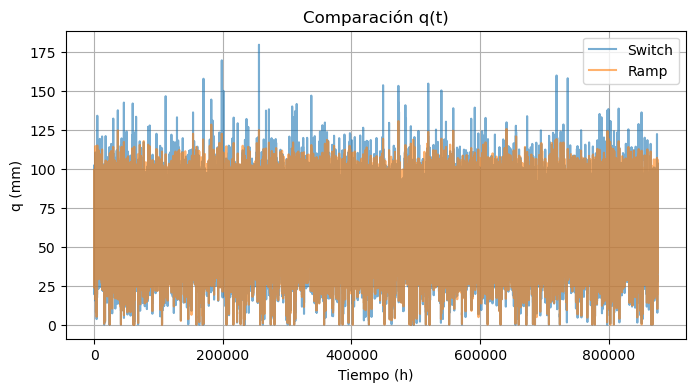

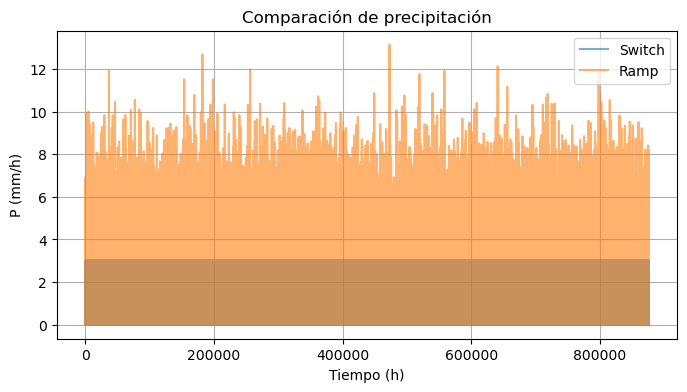

In [7]:
# ==================================================
# Celda 3: Comparación Switch vs Ramp
# ==================================================

T_hours = 876000      # 100 años
dt_minutes = 5.0      # más liviano que 1 minuto

# --- Modelo SWITCH ---
t_sw, q_sw, s_sw, P_sw = simulate_SN14(
    T_hours=T_hours,
    dt_minutes=dt_minutes,
    D0_var=8.0,
    D1_var=64.0,
    qc=65.0,
    qnp=62.0,
    q0=63.0,
    s0=0,
    seed=42
)

# --- Modelo RAMP ---
t_ra, q_ra, s_ra, P_ra = simulate_SN14_ramp(
    T_hours=T_hours,
    dt_minutes=dt_minutes,
    E_star=0.4,
    lambda_ramp=0.2,
    D0_var=8.0,
    D1_var=64.0,
    qc=65.0,
    q0=63.0,
    seed=42
)

print("Switch:", len(t_sw), "puntos")
print("Ramp:", len(t_ra), "puntos")

# --- Graficar q(t) de ambos ---
plt.figure()
plt.plot(t_sw, q_sw, label="Switch", alpha=0.6)
plt.plot(t_ra, q_ra, label="Ramp", alpha=0.6)
plt.xlabel("Tiempo (h)")
plt.ylabel("q (mm)")
plt.title("Comparación q(t)")
plt.legend()
plt.show()

# --- Graficar P(t) de ambos ---
plt.figure()
plt.plot(t_sw, P_sw, label="Switch", alpha=0.6)
plt.plot(t_ra, P_ra, label="Ramp", alpha=0.6)
plt.xlabel("Tiempo (h)")
plt.ylabel("P (mm/h)")
plt.title("Comparación de precipitación")
plt.legend()
plt.show()


Podemos ver que en el modelo switch, la transición entre condiciones secas y húmedas ocurre de manera abrupta: una vez que $q$ supera el umbral $q_c$, el sistema entra inmediatamente en un estado lluvioso con una precipitación casi constante.

En el modelo ramp, la precipitación aumenta gradualmente a medida que $q$ sobrepasa el umbral. 


Entonces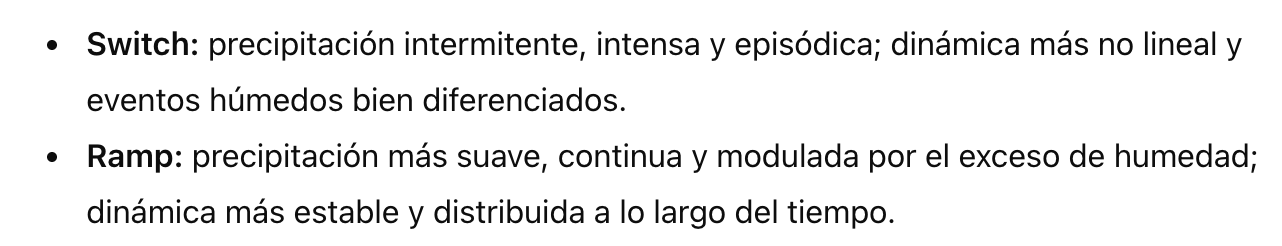

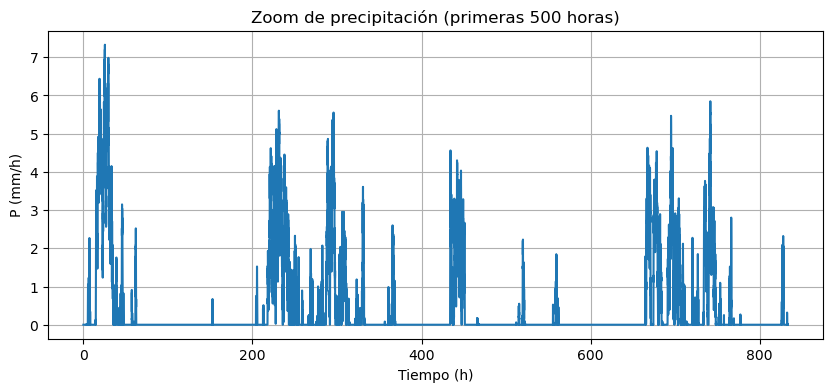

In [8]:
plt.figure(figsize=(10,4))
plt.plot(t[:50000], precip[:50000])  # ~50k puntos = 500 horas si dt=1 min
plt.title("Zoom de precipitación (primeras 500 horas)")
plt.xlabel("Tiempo (h)")
plt.ylabel("P (mm/h)")
plt.grid(True)
plt.show()


El rango que usamos es totalmente razonable, porque

**D0_var = 8** - controla la intensidad del ruido estocástico que empuja a q hacia arriba o abajo
Si D0 es muy bajo, q(t) casi nunca superará q_c ((no hay lluvia))

**D1_var = 64** - controla la intensidad de la lluvia cuando si cruza el umbral

Si D1 es demasiado chico, P(t) queda extremadamente pequeña, si es demasiado grande, lluvia grotesca, no física.


1° Gráfico: 
Muestra cómo evoluciona la variable $q(t)$ en el tiempo

Cuando $q$ sube por encima del umbral (Aprox 60mm), el modelo entra en estado de precipitación

Apenas llueve, $q(t)$ cae rápidamente

**Entonces, la humedad column-integrada $q(t)$ fluctúa de manera continua debido al ruido estocástico del modelo y presenta picos altos que típicamente desencadenan episodios de precipitación.**

**Cuando llueve, $q$ decrece rápidamente, produciendo un patrón característico de picos y caídas.**


2° Gráfico:

Mostramos precip(t) en función del tiempo.


Siempre vale 0 o 3 mm/h, nunca valores intermedios
Entre bandas hay periodos secos donde $P = 0$

Esto es justamente lo que permite calcular **las duraciones de lluvia**, que luego se usan para estimar $t_M$ y para fitear la distribución


**Entonces, la precipitación se comporta como un proceso intermitente tipo "encendido-apagado". Cada episorio lluvioso corresponde a un segmento donde $P(t) = 3mm/h$, mientras que el resto del tiempo la precipitación es nula.**

**La lluvia se activa al superar un nivel crítico de humedad y se mantiene hasta que $q$ es drenado**


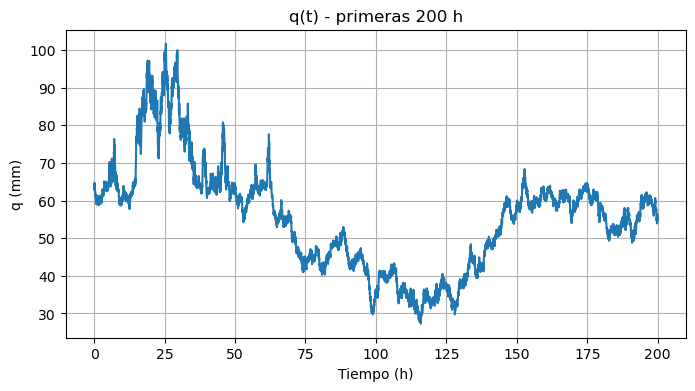

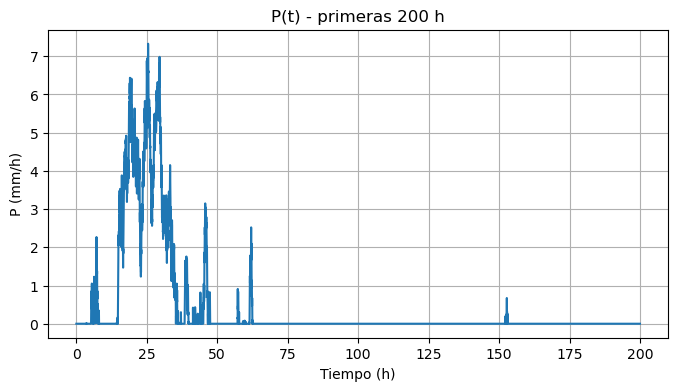

In [9]:
# Zoom en las primeras 200 horas
mask = t <= 200

plt.figure()
plt.plot(t[mask], q[mask])
plt.xlabel("Tiempo (h)")
plt.ylabel("q (mm)")
plt.title("q(t) - primeras 200 h")
plt.show()

plt.figure()
plt.plot(t[mask], precip[mask])
plt.xlabel("Tiempo (h)")
plt.ylabel("P (mm/h)")
plt.title("P(t) - primeras 200 h")
plt.show()


Gráfico 1

Gráfico de $q(t)$ de las primeras 200 hrs. Este zoom muestra cómo se comporta la humedad $q(t)$ en escalas cortas.

Entre 0 y 50hrs, el ascenso rápido y activación de lluvia

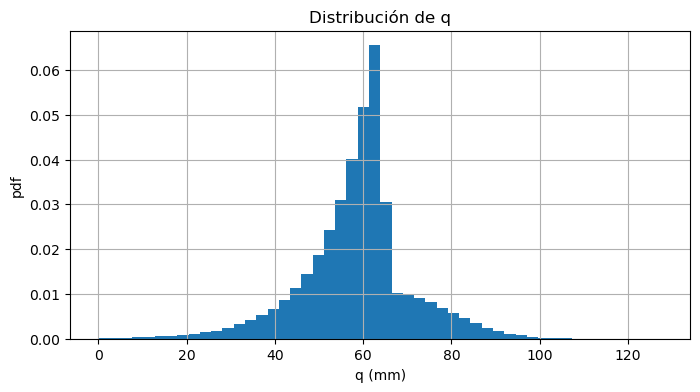

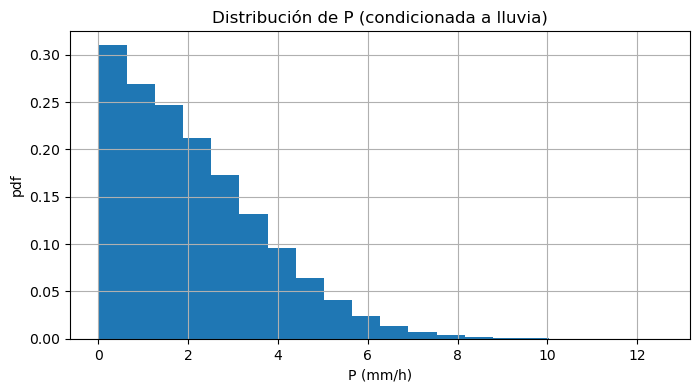

Número de puntos con lluvia: 9746715


In [10]:
# ==================================================
# Celda 4: Distribuciones de q y P
# ==================================================

# Histograma de q
plt.figure()
plt.hist(q, bins=50, density=True)
plt.xlabel("q (mm)")
plt.ylabel("pdf")
plt.title("Distribución de q")
plt.show()

# Histograma de precipitación (solo donde hay lluvia)
P_positive = precip[precip > 0]

plt.figure()
plt.hist(P_positive, bins=20, density=True)
plt.xlabel("P (mm/h)")
plt.ylabel("pdf")
plt.title("Distribución de P (condicionada a lluvia)")
plt.show()

print("Número de puntos con lluvia:", len(P_positive))


Número de episodios lluviosos: 313585
Duración media lluvia (h): 2.5901310649425198
tM lluvia (h) = var/mean: 40.40880562808687

Número de episodios secos: 313585
Duración media seco (h): 11.377374024055147
tM seco (h) = var/mean: 256.09776631361166


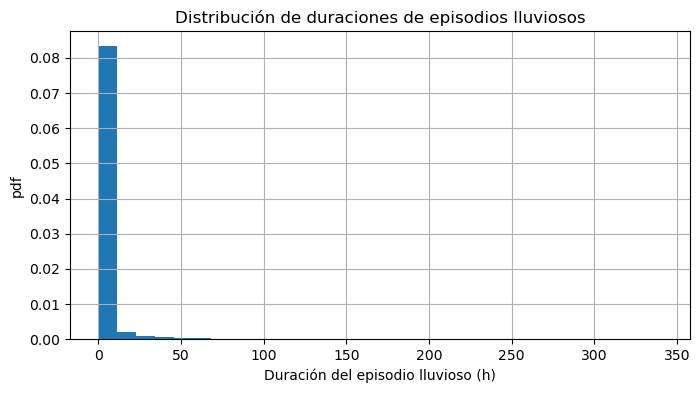

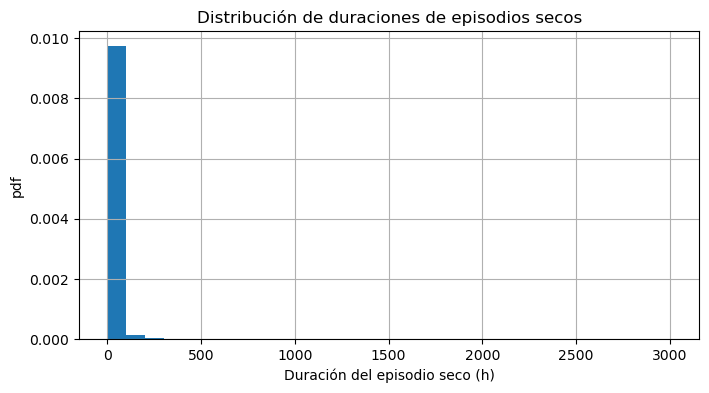

In [11]:
# ==================================================
# Celda 5: Duraciones de spells y cálculo de tM
# ==================================================

dt_hours = dt_minutes / 60.0

# Duraciones de episodios lluviosos (wet spells)
wet_durations = get_spell_durations(s, dt_hours, wet=True)
# Duraciones de episodios secos (dry spells)
dry_durations = get_spell_durations(s, dt_hours, wet=False)

tM_wet = tM_from_durations(wet_durations)
tM_dry = tM_from_durations(dry_durations)

print("Número de episodios lluviosos:", len(wet_durations))
print("Duración media lluvia (h):", np.mean(wet_durations))
print("tM lluvia (h) = var/mean:", tM_wet)

print("\nNúmero de episodios secos:", len(dry_durations))
print("Duración media seco (h):", np.mean(dry_durations))
print("tM seco (h) = var/mean:", tM_dry)

# Histogramas de duraciones (lluvia)
plt.figure()
plt.hist(wet_durations, bins=30, density=True)
plt.xlabel("Duración del episodio lluvioso (h)")
plt.ylabel("pdf")
plt.title("Distribución de duraciones de episodios lluviosos")
plt.show()

# Histogramas de duraciones (seco)
plt.figure()
plt.hist(dry_durations, bins=30, density=True)
plt.xlabel("Duración del episodio seco (h)")
plt.ylabel("pdf")
plt.title("Distribución de duraciones de episodios secos")
plt.show()


Resultados (lluvia):
D0^2 =   2.0 mm^2/h  | mean dur =  1.200 h  | var dur =    7.270 h^2  | tM ≈  6.058 h
D0^2 =   4.0 mm^2/h  | mean dur =  1.225 h  | var dur =    6.257 h^2  | tM ≈  5.106 h
D0^2 =   8.0 mm^2/h  | mean dur =  1.295 h  | var dur =    6.958 h^2  | tM ≈  5.371 h
D0^2 =  16.0 mm^2/h  | mean dur =  1.298 h  | var dur =    6.630 h^2  | tM ≈  5.107 h
D0^2 =  32.0 mm^2/h  | mean dur =  1.305 h  | var dur =    6.657 h^2  | tM ≈  5.103 h


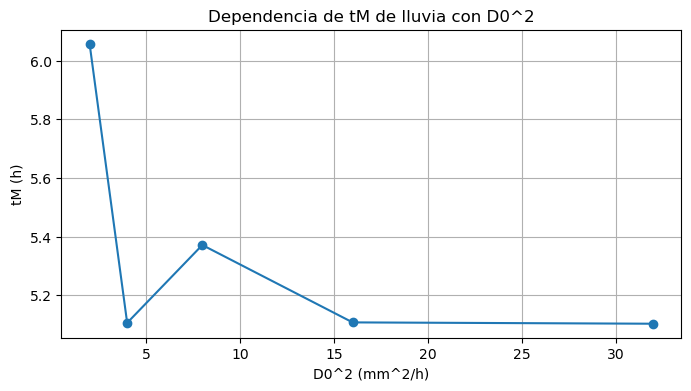

In [12]:
# ==================================================
# Celda 6: Sensibilidad de tM a D0
# ==================================================

D0_var_values = [2.0, 4.0, 8.0, 16.0, 32.0]  # diferentes valores de D0^2 (mm^2/h)
results = []

T_hours_exp = 3000   # simulación un poco más larga para mejores estadísticas
dt_minutes = 1.0
dt_hours = dt_minutes / 60.0

for D0_var in D0_var_values:
    t, q, s, precip = simulate_SN14(
        T_hours=T_hours_exp,
        dt_minutes=dt_minutes,
        D0_var=D0_var,
        D1_var=64.0,
        seed=0
    )

    wet_durations = get_spell_durations(s, dt_hours, wet=True)
    tM = tM_from_durations(wet_durations)

    results.append((D0_var, np.mean(wet_durations), np.var(wet_durations), tM))

print("Resultados (lluvia):")
for D0_var, mean_dur, var_dur, tM in results:
    print(f"D0^2 = {D0_var:5.1f} mm^2/h  | "
          f"mean dur = {mean_dur:6.3f} h  | "
          f"var dur = {var_dur:8.3f} h^2  | "
          f"tM ≈ {tM:6.3f} h")

# Graficar tM vs D0^2
D0_var_arr = np.array([r[0] for r in results])
tM_arr = np.array([r[3] for r in results])

plt.figure()
plt.plot(D0_var_arr, tM_arr, marker='o')
plt.xlabel("D0^2 (mm^2/h)")
plt.ylabel("tM (h)")
plt.title("Dependencia de tM de lluvia con D0^2")
plt.show()


Número de episodios usados para el fit: 438
Duración mínima, máxima (h): 0.016666666666666666 21.133333333333333
Número de bins usados en el fit: 11

Parámetros ajustados:
A   = 2.5083e-01
tau = 0.872
tL  = 4.770 h   (escala de corte)


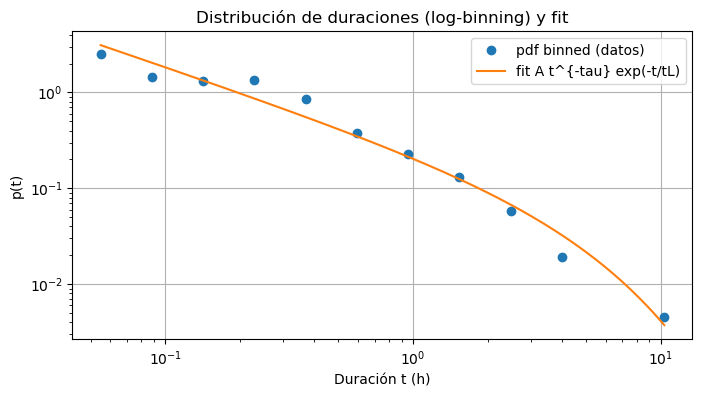

In [13]:
# ==========================================
# Nueva Celda 7
# Fit p(t) = A t^{-tau} exp(-t/tL)
# con binning logarítmico y ajuste en log(p)
# ==========================================

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1) Elegimos las duraciones a usar (lluvia; puede cambiar a dry_durations)
dur = wet_durations.copy()
dur = dur[dur > 0]   # quitar posibles ceros

print("Número de episodios usados para el fit:", len(dur))
print("Duración mínima, máxima (h):", dur.min(), dur.max())

# 2) Binning logarítmico
nbins = 15  # puede ajustar este número (10–20 suele ir bien)

t_min = dur.min()
t_max = dur.max()

bin_edges = np.logspace(np.log10(t_min), np.log10(t_max), nbins + 1)
counts, edges = np.histogram(dur, bins=bin_edges)

bin_widths  = np.diff(edges)
bin_centers = np.sqrt(edges[:-1] * edges[1:])   # centro geométrico

N = len(dur)
pdf = counts / (N * bin_widths)                 # densidad p(t)

# 3) Seleccionar sólo bins con suficientes datos
#    (similar a lo que hace el paper: descartar bins con pocos eventos)
min_counts = 10   # umbral: al menos 10 eventos por bin
mask = (counts >= min_counts) & (pdf > 0)

t_data     = bin_centers[mask]
p_data     = pdf[mask]
log_p_data = np.log(p_data)

print("Número de bins usados en el fit:", len(t_data))

# 4) Modelo en espacio logarítmico:
#    log p(t) = logA - tau log t - t/tL
def log_p_model(t, logA, tau, tL):
    return logA - tau * np.log(t) - t / tL

# Valores iniciales razonables
logA0 = np.log(p_data[0])
tau0  = 1.0              # exponente inicial (positivo)
tL0   = np.mean(dur)     # escala típica ~ media

p0 = (logA0, tau0, tL0)

# Bounds: imponemos tau>0, tL>0
# logA lo dejamos bastante libre
lower_bounds = [-50.0,  0.0,      dt_hours]      # dt_hours ~ mínimo razonable
upper_bounds = [ 50.0,  5.0, 10.0 * dur.max()]   # tL hasta 10 veces la duración máxima

# 5) Ajuste no lineal en log(p)
popt, pcov = curve_fit(
    log_p_model,
    t_data,
    log_p_data,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=20000
)

logA_hat, tau_hat, tL_hat = popt
A_hat = np.exp(logA_hat)

print("\nParámetros ajustados:")
print(f"A   = {A_hat:.4e}")
print(f"tau = {tau_hat:.3f}")
print(f"tL  = {tL_hat:.3f} h   (escala de corte)")

# 6) Gráfico: pdf binned + fit, en escala log-log
t_fit = np.logspace(np.log10(t_data.min()), np.log10(t_data.max()), 200)
p_fit = A_hat * t_fit**(-tau_hat) * np.exp(-t_fit / tL_hat)

plt.figure()
plt.loglog(t_data, p_data, 'o', label='pdf binned (datos)')
plt.loglog(t_fit, p_fit, '-', label='fit A t^{-tau} exp(-t/tL)')
plt.xlabel("Duración t (h)")
plt.ylabel("p(t)")
plt.title("Distribución de duraciones (log-binning) y fit")
plt.legend()
plt.show()


# Estudio de la solución analítica de dry spell duration

Recordemos y entendamos que un dry spell es un episodio continuo en el que el sistema está en **estado seco** (o sea que no precipita)

_el tiempo que demora $q(t)$, partiendo por debajo del umbral, en alcanzar el umbral de inicio de lluvia._

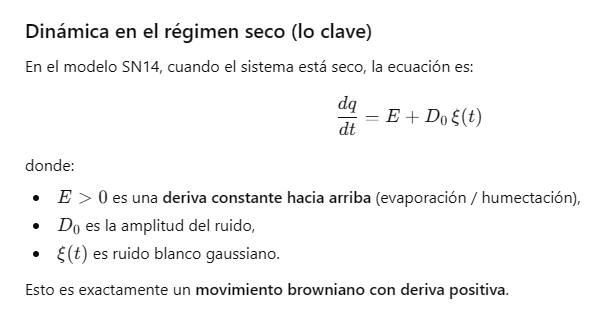

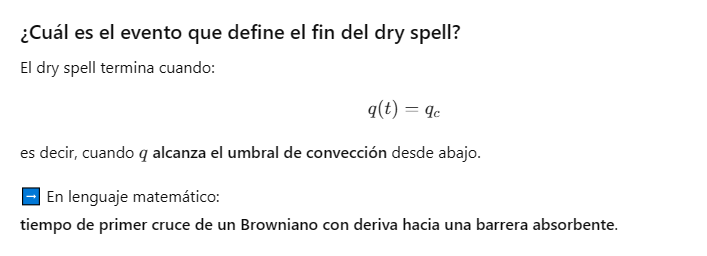

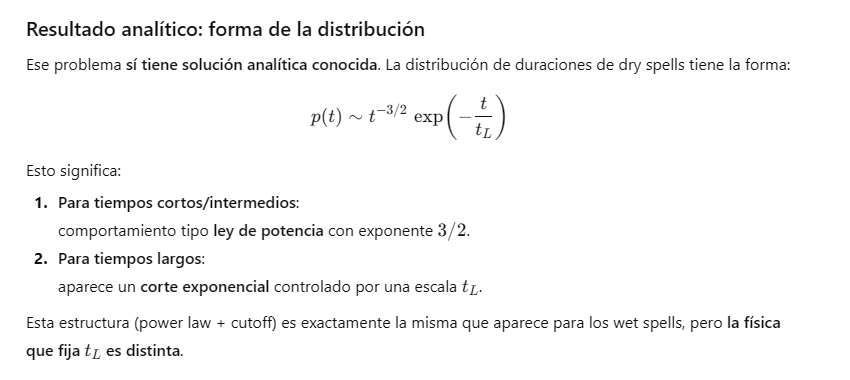

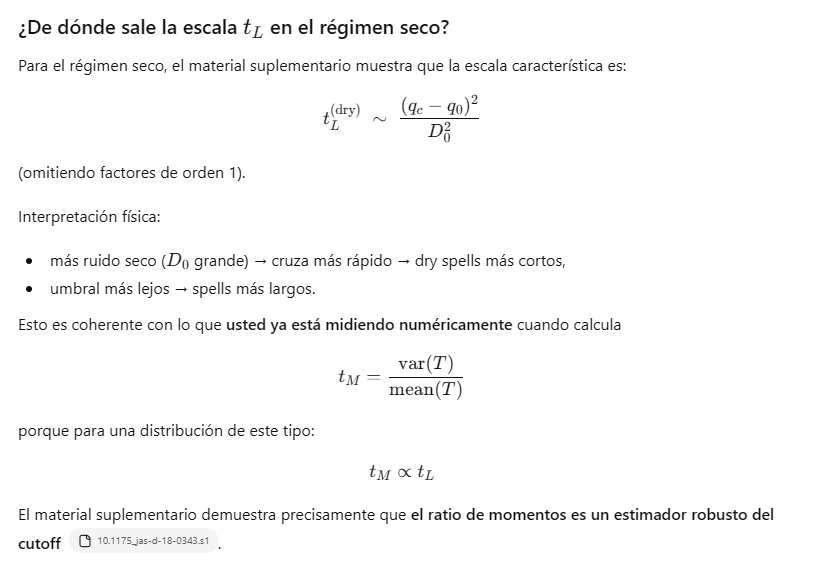

In [ ]:
# Análisis: simulación numérica de dry-spell durations y comparación con la ecuación (6)
# Se generan dos variantes: 1) sin tratamiento (q puede ser negativo) y 2) con reflexión en q=0.
# Reutiliza las funciones `simulate_SN14` y `get_spell_durations` definidas arriba.

# Instrucciones: ejecutar esta celda de código (celda siguiente) para producir los resultados.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# Parámetros para las simulaciones (ajusta N_runs y T_hours según necesites)
N_runs = 12
T_hours_run = 3000.0
dt_minutes = 1.0
dt_hours = dt_minutes / 60.0

# Distancia al umbral b (usa qc, q0 definidos arriba en el notebook)
try:
    b = qc - q0
except NameError:
    # valores por defecto si no están en el workspace
    qc = 65.0
    q0 = 63.0
    b = qc - q0

# 1) Variante A: versión del modelo sin piso (permitir q negativo)
def simulate_no_floor(T_hours=1000.0, dt_minutes=1.0, E_star=0.4, P_star=3.0, D0_var=8.0, D1_var=64.0, qc=65.0, q0=63.0, qnp=62.0, s0=0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = dt_minutes / 60.0
    nsteps = int(T_hours / dt)
    D0 = np.sqrt(D0_var)
    D1 = np.sqrt(D1_var)
    t = np.linspace(0, T_hours, nsteps+1)
    q = np.zeros(nsteps+1)
    s = np.zeros(nsteps+1, dtype=int)
    precip = np.zeros(nsteps+1)
    q[0] = q0
    s[0] = s0
    precip[0] = P_star if s0 == 1 else 0.0
    for n in range(nsteps):
        if s[n] == 0:
            drift = E_star
            D = D0
        else:
            drift = -P_star
            D = D1
        dW = np.sqrt(dt) * np.random.randn()
        q[n+1] = q[n] + drift*dt + D * dW
        # no floor: permitimos q<0
        if s[n] == 0 and q[n+1] >= qc:
            s[n+1] = 1
        elif s[n] == 1 and q[n+1] <= qnp:
            s[n+1] = 0
        else:
            s[n+1] = s[n]
        precip[n+1] = P_star if s[n+1] == 1 else 0.0
    return t, q, s, precip

# 2) Variante B: usar simulate_SN14 con reflexión (q_floor_mode='reflect')
# Recolectar duraciones de dry spells para ambas variantes
all_wet_durations_A = []
all_wet_durations_B = []
for i in range(N_runs):
    seed = i
    # Variante A: sin piso
    tA, qA, sA, pA = simulate_no_floor(T_hours=T_hours_run, dt_minutes=dt_minutes, E_star=0.4, D0_var=8.0, D1_var=64.0, qc=qc, q0=q0, qnp=62.0, s0=0, seed=seed)
    wetA = get_spell_durations(sA, dt_hours, wet=True)
    if len(wetA) > 0:
        all_wet_durations_A.append(wetA)
    # Variante B: reflect (usa la función del notebook)
    try:
        tB, qB, sB, pB = simulate_SN14(T_hours=T_hours_run, dt_minutes=dt_minutes, E_star=0.4, D0_var=8.0, D1_var=64.0, qc=qc, qnp=62.0, q0=q0, s0=0, seed=seed, q_floor_mode='reflect')
    except TypeError:
        tB, qB, sB, pB = simulate_SN14(T_hours=T_hours_run, dt_minutes=dt_minutes, E_star=0.4, D0_var=8.0, D1_var=64.0, qc=qc, qnp=62.0, q0=q0, s0=0, seed=seed)
    wetB = get_spell_durations(sB, dt_hours, wet=True)
    if len(wetB) > 0:
        all_wet_durations_B.append(wetB)

times_A = np.concatenate(all_wet_durations_A) if len(all_wet_durations_A) > 0 else np.array([])
times_B = np.concatenate(all_wet_durations_B) if len(all_wet_durations_B) > 0 else np.array([])
print('Collected events A,B =', len(times_A), len(times_B))

def analytic_pdf(t, b, E_star, D0):
    pref = b / np.sqrt(2.0 * np.pi * (D0**2) * (t**3))
    return pref * np.exp(E_star * b / (D0**2)) * np.exp(-b**2 / (2.0 * (D0**2) * t)) * np.exp(- (E_star**2) * t / (2.0 * (D0**2)))

D0 = np.sqrt(8.0)
if times_A.size > 0 or times_B.size > 0:
    tmin = min(times_A.min() if times_A.size else 1.0, times_B.min() if times_B.size else 1.0)
    tmax = max(times_A.max() if times_A.size else 1.0, times_B.max() if times_B.size else 1.0)
else:
    tmin = 1e-3
    tmax = 1.0
bins = np.logspace(np.log10(max(1e-6, tmin)), np.log10(tmax + 1e-6), 30)
plt.figure(figsize=(8,5))
for times, label, c in [(times_A, 'allow negative', 'C0'), (times_B, 'reflect', 'C1')]:
    if times.size == 0:
        continue
    counts, edges = np.histogram(times, bins=bins)
    widths = np.diff(edges)
    centers = np.sqrt(edges[:-1] * edges[1:])
    pdf = counts / (len(times) * widths)
    plt.loglog(centers, pdf, 'o', label=f'data ({label})', color=c)
tfit = np.logspace(np.log10(bins[0] * 1.0), np.log10(bins[-1] * 1.0), 300)
pfit = analytic_pdf(tfit, b, 0.4, D0)
plt.loglog(tfit, pfit, '-', color='k', label='analytic eq.6')
plt.xlabel('t (h)')
plt.ylabel('p(t)')
plt.legend()
plt.title('Dry-spell durations: numeric vs analytic (ec.6)')
plt.grid(True, which='both', ls=':')
plt.show()

for name, arr in [('allow negative', times_A), ('reflect', times_B)]:
    if arr.size:
        print(f'{name}: n={len(arr)}, mean={arr.mean():.3f} h, median={np.median(arr):.3f} h')
    else:
        print(f'{name}: no events')


IndentationError: unexpected indent (3673100202.py, line 26)